In [3]:
from datetime import datetime, timedelta
import pandas as pd
import requests
import re
import os
from bs4 import BeautifulSoup
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

from datetime import datetime

def get_exchange_rates(target_currencies=None):
    url = "https://rate.bot.com.tw/xrt?Lang=en-US"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'title': '牌告匯率'})
    exchange_rates = []

    for row in table.find_all('tr'):
        currency_td = row.find('td', {'data-table': 'Currency'})
        if not currency_td:
            continue
        div = currency_td.find('div', class_='visible-phone print_hide')
        if not div:
            continue
        
        # 取出完整幣別字串，例如 " American Dollar (USD) "
        currency_full_name = div.text.strip()
        
        # 使用正則表達式擷取括號中的代碼，例如 USD
        match = re.search(r'\((\w+)\)', currency_full_name)
        if not match:
            continue

        currency_code = match.group(1)

        if currency_code in target_currencies:
            cells = row.find_all('td')
            if len(cells) >= 5:
                cash_buy = cells[1].text.strip()
                cash_sell = cells[2].text.strip()
                spot_buy = cells[3].text.strip()
                spot_sell = cells[4].text.strip()

                exchange_rates.append({
                    'currency': currency_code,
                    'cash_buy': cash_buy,
                    'cash_sell': cash_sell,
                    'spot_buy': spot_buy,
                    'spot_sell': spot_sell
                })

    return exchange_rates

# 測試看看
rates = get_exchange_rates(['USD', 'EUR', 'CNY'])
for rate in rates:
    print(rate)


{'currency': 'USD', 'cash_buy': '32.105', 'cash_sell': '32.775', 'spot_buy': '32.455', 'spot_sell': '32.555'}
{'currency': 'EUR', 'cash_buy': '36.06', 'cash_sell': '37.4', 'spot_buy': '36.68', 'spot_sell': '37.08'}
{'currency': 'CNY', 'cash_buy': '4.345', 'cash_sell': '4.507', 'spot_buy': '4.417', 'spot_sell': '4.467'}


In [ ]:
LINE Message API

RLpQmZZf7Lpg0rgi/8z4hZuATxbNEBtkKtQs15mgnStyXwgWaxFzedNlzaqo0X5BDyfI1cw4zz8Hkl7RndRIvkt75u3okxeelWaUc6uFcaWHwOeeRpgxt5g5KcfXVVu+vCj2OBBzXzM+1rJhgViyLQdB04t89/1O/w1cDnyilFU=

['history/USD.csv', 'history/EUR.csv', 'history/CNY.csv']


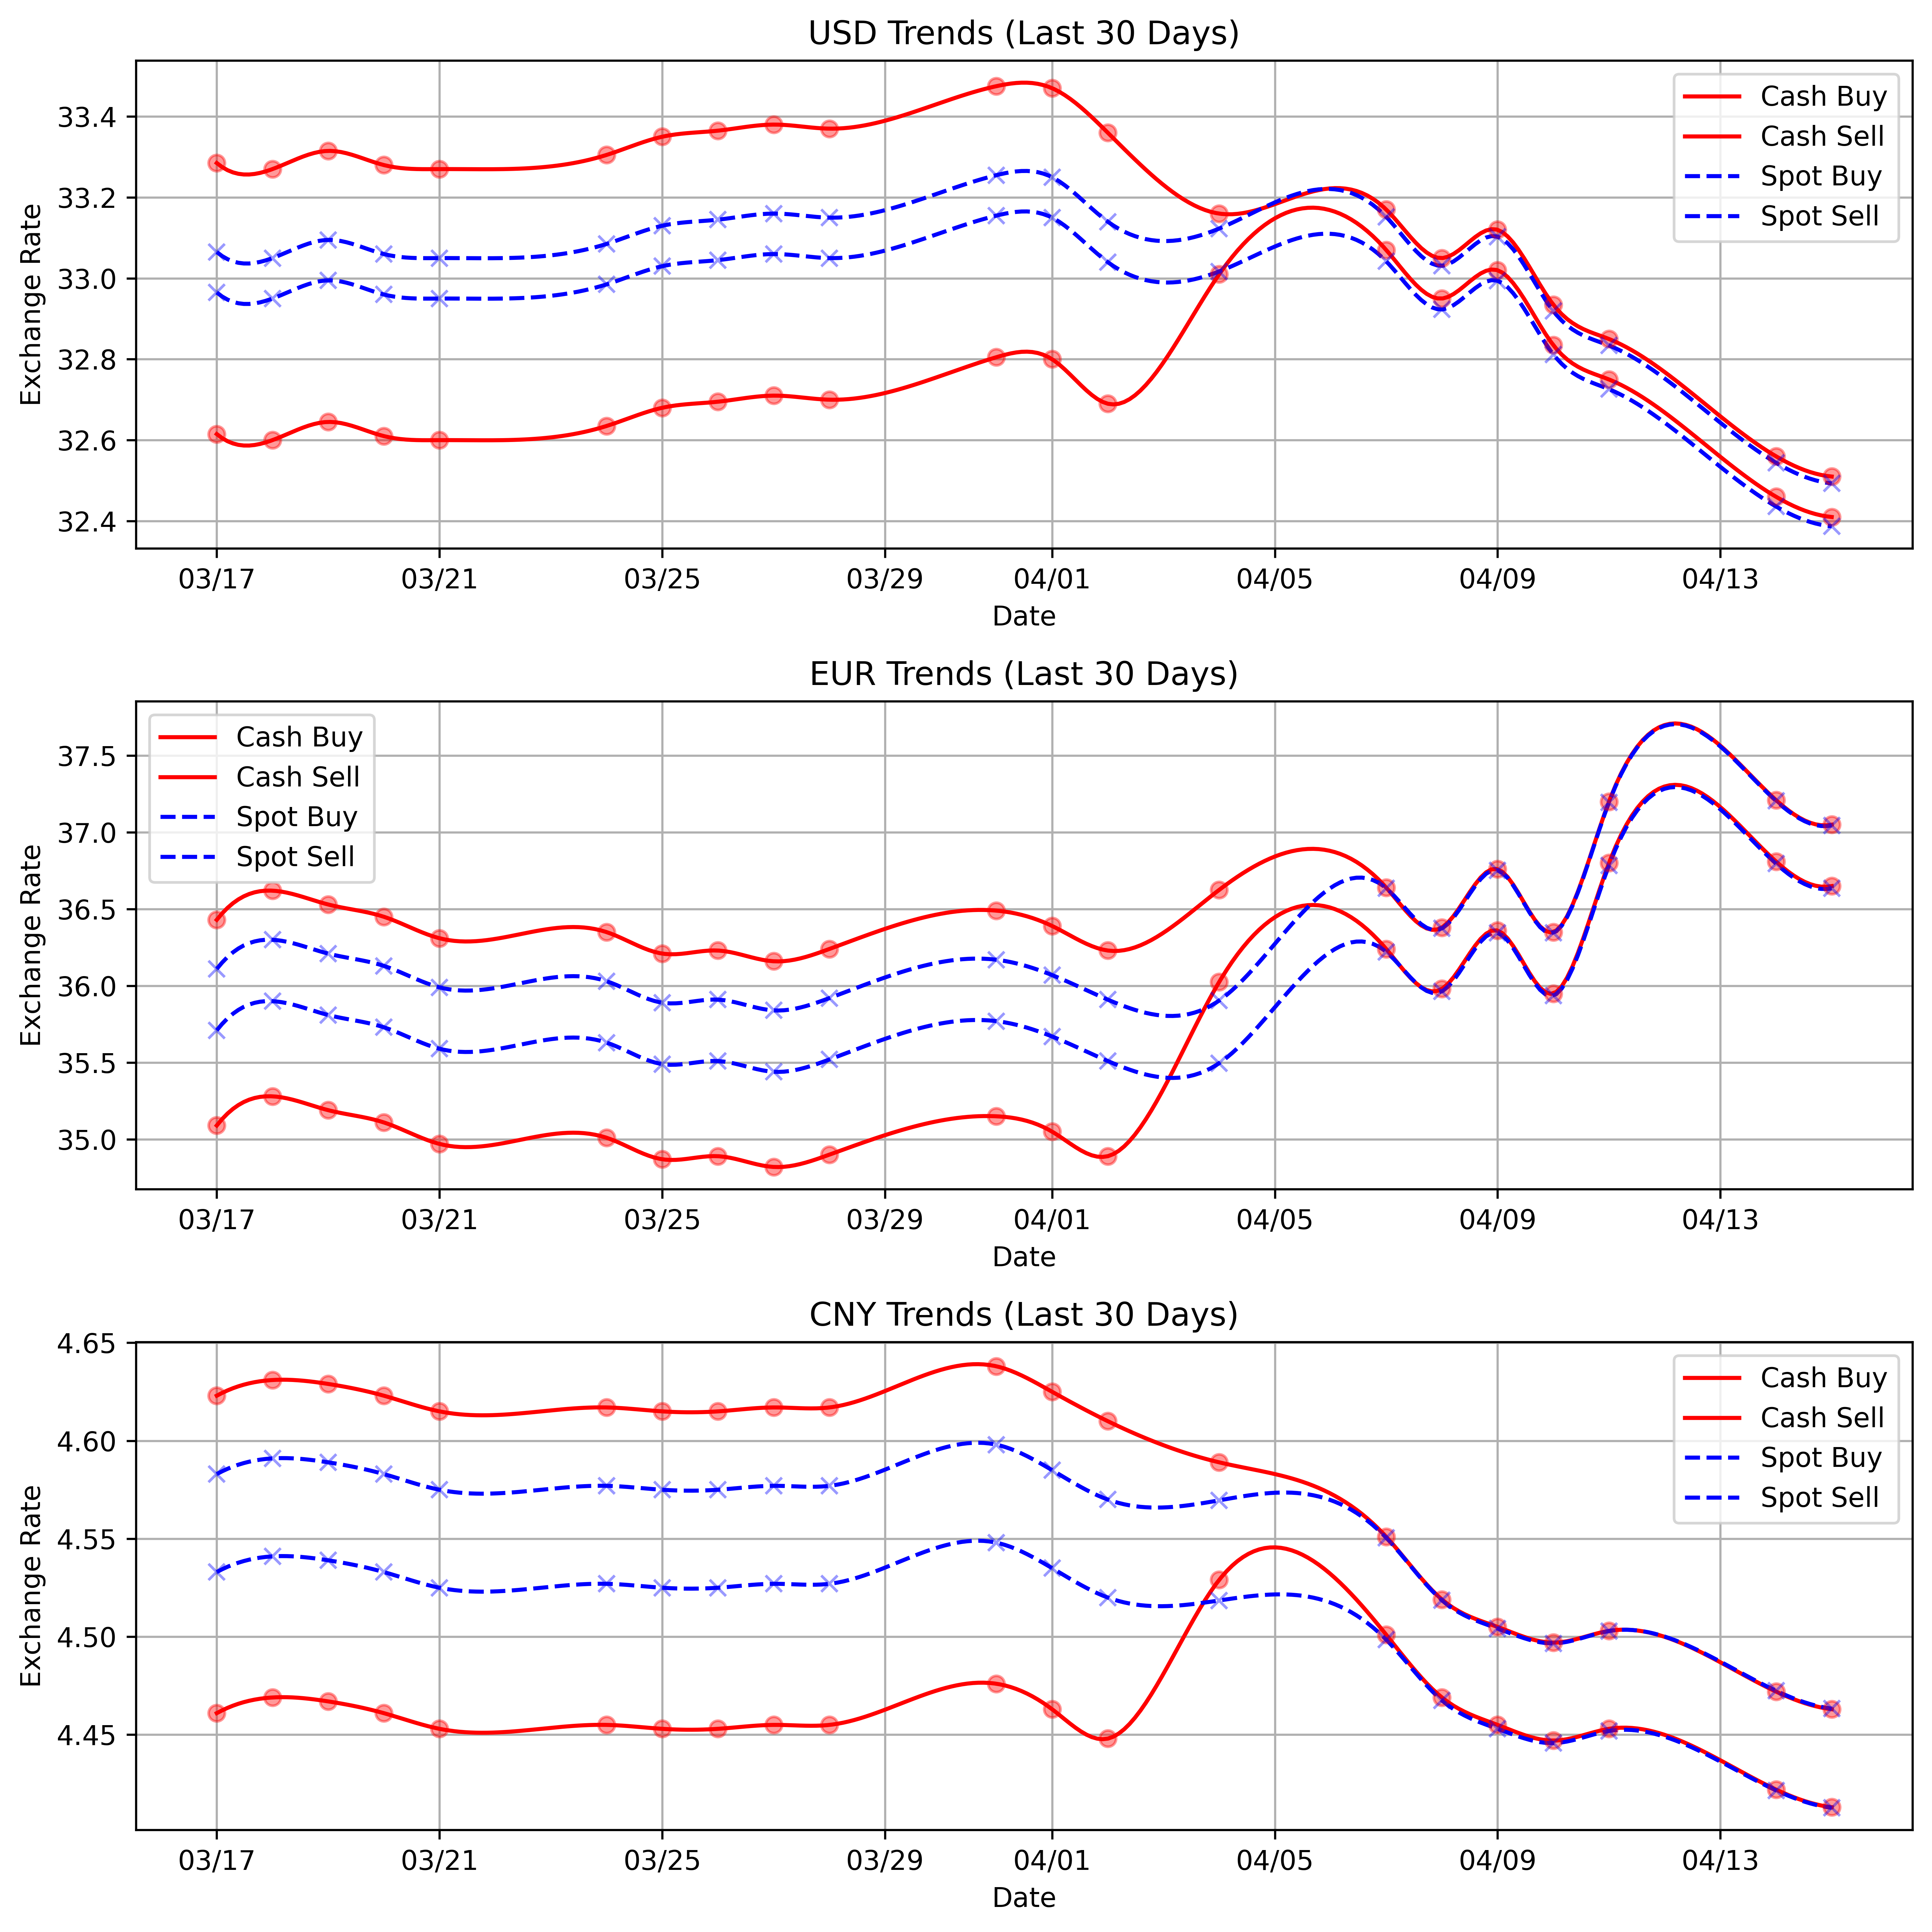

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline

filepath = ['history/USD.csv','history/EUR.csv','history/CNY.csv']
print(filepath)

fig, ax = plt.subplots(3,1,figsize=(10,10), dpi=600)
for i, file in enumerate(filepath):
    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d", errors='coerce')
    df = df.dropna(subset=["Date"])
    df = df[df["Date"] >= datetime.today() - timedelta(days=30)]

    x = mdates.date2num(df["Date"])
    x_smooth = np.linspace(x.min(), x.max(), 300)

    def smooth_curve(y_values):
        if len(x) < 4:
            return x, y_values
        spline = make_interp_spline(x, y_values, k=3)
        return x_smooth, spline(x_smooth)

    x1, y1 = smooth_curve(df["Buy_cash"].values)
    x2, y2 = smooth_curve(df["Sell_cash"].values)
    x3, y3 = smooth_curve(df["Buy_spot"].values)
    x4, y4 = smooth_curve(df["Sell_spot"].values)

    ax[i].plot(x1, y1, '-', color='red', label="Cash Buy")
    ax[i].plot(x2, y2, '-', color='red', label="Cash Sell")
    ax[i].plot(x3, y3, '--', color='blue', label="Spot Buy")
    ax[i].plot(x4, y4, '--', color='blue', label="Spot Sell")

    # 原始資料點標記
    ax[i].plot(df["Date"], df["Buy_cash"], 'o', color='red', alpha=0.4)
    ax[i].plot(df["Date"], df["Sell_cash"], 'o', color='red', alpha=0.4)
    ax[i].plot(df["Date"], df["Buy_spot"], 'x', color='blue', alpha=0.4)
    ax[i].plot(df["Date"], df["Sell_spot"], 'x', color='blue', alpha=0.4)

    ax[i].set_title(f"{file[8:11]} Trends (Last 30 Days)")
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Exchange Rate")
    ax[i].legend(loc='best')
    ax[i].grid(True)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.tight_layout()
plt.savefig(os.path.join(script_dir, image_filename))
plt.show()
plt.close()